# Подбор подходящей модели, её обучение и валидация

In [4]:
import sys
import os
import numpy as np
import pandas as pd
import optuna
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from optuna.samplers import TPESampler

In [5]:
current_dir = os.path.abspath(os.path.dirname('__file__'))
prep_path = os.path.join(current_dir, '..', 'src')
sys.path.append(prep_path)
from preprocessing import make_preprocess_pipeline
from features import make_feature_pipeline

------------

## В качестве базовой модели выберем `LogisticRegression`

### Загрузим и обработаем данные по шаблону из Preprocessing

In [9]:
df = pd.read_csv('../data/cs-training.csv')

X = df.drop(['SeriousDlqin2yrs', 'Unnamed: 0'], axis=1)
y = df['SeriousDlqin2yrs']

In [10]:
X.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [11]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Подберём гиперпараметры модели

In [13]:
pipe = Pipeline([
    ('preprocess', make_preprocess_pipeline()),
    ('features', make_feature_pipeline()),
    ('model', LogisticRegression())
])

In [14]:
param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [1, 2, 3, 5, 10, 20, 50],
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],
    'model__fit_intercept': [True, False]
}

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
)

gs.fit(X_train_raw, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('mi_imputer',
                                                         MonthlyIncomeImputer(model_path='../models/bayesian_mi.joblib')),
                                                        ('nd_imputer',
                                                         NumberOfDependentsImputer(model_path='../models/bayesian_nd.joblib')),
                                                        ('pastdue',
                                                         PastDueAggregator()),
                                                        ('winsor',
                                                         Winsorizer()),
                                                        ('log',
                                                         LogTransformer(cols=['DebtRatio',
                                                                              'PastDueAggregate...
                                                        ('scaler',
                                                         MinMaxScaler())])),
                                       ('features',
                                        Pipeline(steps=[('poly',
                                                         PolynomialFeatures(include_bias=False,
                                                                            interaction_only=True))])),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [1, 2, 3, 5, 10, 20, 50],
                         'model__class_weight': [None, 'balanced'],
                         'model__fit_intercept': [True, False],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['saga']},
             scoring='roc_auc')

In [15]:
gs.best_score_
gs.best_params_

{'model__C': 1,
 'model__class_weight': 'balanced',
 'model__fit_intercept': True,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

In [16]:
best_pipe = gs.best_estimator_
y_pred = best_pipe.predict_proba(X_val_raw)[:, 1]
print(f'Logistic Regression AUC-ROC: {roc_auc_score(y_val, y_pred):.4f}')

Logistic Regression AUC-ROC: 0.8583


In [17]:
lr_pred = best_pipe.predict(X_val_raw)
print(classification_report(y_val, lr_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87     41992
           1       0.20      0.79      0.32      3008

    accuracy                           0.78     45000
   macro avg       0.59      0.78      0.59     45000
weighted avg       0.93      0.78      0.83     45000



### Базовая модель уже показывает неплохой результат, значит, наши данные хорошо описываются линейными моделями. Свой вклад также внесли фичи, полученные с помощью `PolynomialFeatures`

### Однако в случае использования `PolynomialFeatures` теряется часть интерпретируемости коэффициентов модели. Если бизнесу важнее интерпретируемость, то можно немного пожертвовать качеством в её пользу и обучать модель без дополнительных фичей

----------

## Посмотрим, как покажет себя `RandomForest`. Подберем гиперпараметры для леса с помощью `Optuna`

In [21]:
def objective(trial):

    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 0.3, 0.5, None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
    }

    pipe = Pipeline([
        ('preprocess', make_preprocess_pipeline()),
        # features.py не нужен для деревьев
        ('model', RandomForestClassifier(**rf_params))
    ])

    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42
    )

    scores = cross_val_score(
        pipe,
        X_train_raw,
        y_train,
        scoring='roc_auc',
        cv=cv,
    )

    return scores.mean()

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

study.optimize(
    objective,
    n_trials=5,
    show_progress_bar=True
)

[I 2026-01-15 13:06:44,319] A new study created in memory with name: no-name-c7e228dc-bd79-451c-91f1-90848f3c7139


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2026-01-15 14:01:00,907] Trial 0 finished with value: 0.7597612526660567 and parameters: {'n_estimators': 425, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7597612526660567.
[I 2026-01-15 14:05:21,955] Trial 1 finished with value: 0.8574877904669462 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.8574877904669462.
[I 2026-01-15 14:22:21,857] Trial 2 finished with value: 0.8539748260648695 and parameters: {'n_estimators': 474, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 0.5, 'bootstrap': False, 'class_weight': None}. Best is trial 1 with value: 0.8574877904669462.
[I 2026-01-15 14:33:23,500] Trial 3 finished with value: 0.8481450064825854 and parameters: {'n_estimators': 383, 'm

In [22]:
print("Лучшие параметры:", study.best_params)
print("Лучший ROC-AUC (CV):", study.best_value)

Лучшие параметры: {'n_estimators': 700, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.3, 'bootstrap': True, 'class_weight': 'balanced'}
Лучший ROC-AUC (CV): 0.8574877904669462


In [23]:
best_rf = Pipeline([
    ('preprocess', make_preprocess_pipeline()),
    ('model', RandomForestClassifier(
        **study.best_params,
        random_state=42,
    ))
])
best_rf.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('mi_imputer',
                                  MonthlyIncomeImputer(model_path='../models/bayesian_mi.joblib')),
                                 ('nd_imputer',
                                  NumberOfDependentsImputer(model_path='../models/bayesian_nd.joblib')),
                                 ('pastdue', PastDueAggregator()),
                                 ('winsor', Winsorizer()),
                                 ('log',
                                  LogTransformer(cols=['DebtRatio',
                                                       'PastDueAggregated'])),
                                 ('scaler', MinMaxScaler())])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        max_features=0.3, min_samples_leaf=4,
                                        min_samples_split=5, n_estimators=700,
                                        random_state=42))])

In [24]:
rf_pred = best_rf.predict_proba(X_val_raw)[:, 1]
print(f'RandomForest AUC-ROC: {roc_auc_score(y_val, rf_pred):.4f}')

RandomForest AUC-ROC: 0.8593


### RandomForest показал себя чуть лучше
### Посмотрим на важность признаков

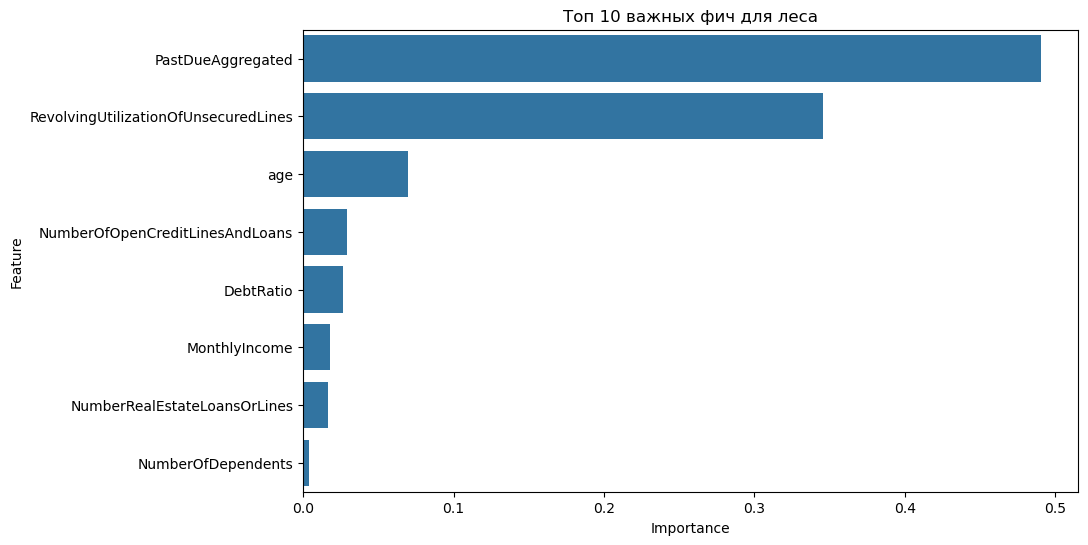

In [66]:
feature_names = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents',
       'PastDueAggregated']

rf_imp = pd.DataFrame({"Feature": feature_names, "Importance": best_rf['model'].feature_importances_}).sort_values("Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_imp.head(10), x="Importance", y="Feature")
plt.title("Топ 10 важных фич для леса")
plt.show()

## Можно сделать пару выводов из этих данных:
### 1. Предположение о потенциальной важности признака `age`, сделанное еще в `EDA`, оказалось верным
### 2. Наш агрегированный показатель `PastDueAggregated` является самым полезным признаком, а сама модель показывает хороший результат (`0.859` AUC-ROC)

----------

# Перейдем к градиентному бустингу, но сначала порассуждаем насчет выбора конкретной его реализации:

## Очевидно, CatBoost не подходит для нашей задачи, т.к. категориальных фичей вообще нет
## Выбор лежит между LightGBM и XGBoost

## LightGBM обучается значительно быстрее XGBoost, лучше улавливает зависимости за счет Leaf-wise роста (что, однако, создает риск переобучения), легко настраивается, а также к нему проще прикрутить `Optuna`.

### Переходим к построению модели:

In [33]:
def objective(trial):

    lgbm_params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",

        # основные параметры
        "n_estimators": trial.suggest_int("n_estimators", 200, 1200),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),

        # сложность дерева
        "num_leaves": trial.suggest_int("num_leaves", 8, 128),
        "max_depth": trial.suggest_int("max_depth", 3, 15),

        # регуляризация
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "lambda_l1": trial.suggest_float("lambda_l1", 1.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 1.0, 10.0),

        # stochasticity
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),

        # imbalance
        "class_weight": "balanced",

        # misc
        "random_state": 42,
        "verbosity": -1,
    }

    pipe = Pipeline([
        ("preprocess", make_preprocess_pipeline()),
        ("model", LGBMClassifier(**lgbm_params)),
    ])

    cv = StratifiedKFold(
        n_splits=10,
        shuffle=True,
        random_state=42
    )

    scores = cross_val_score(
        pipe,
        X_train_raw,
        y_train,
        scoring="roc_auc",
        cv=cv,
    )

    return scores.mean()


In [34]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(
    objective,
    n_trials=15,
    show_progress_bar=True
)


[I 2026-01-15 14:39:51,109] A new study created in memory with name: no-name-f509c84f-610a-4a34-85a7-6e5f034fc164


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2026-01-15 14:40:59,548] Trial 0 finished with value: 0.836977706417087 and parameters: {'n_estimators': 574, 'learning_rate': 0.08927180304353628, 'num_leaves': 96, 'max_depth': 10, 'min_data_in_leaf': 48, 'lambda_l1': 2.403950683025824, 'lambda_l2': 1.5227525095137953, 'feature_fraction': 0.9464704583099741, 'bagging_fraction': 0.8404460046972835, 'bagging_freq': 8}. Best is trial 0 with value: 0.836977706417087.
[I 2026-01-15 14:41:18,117] Trial 1 finished with value: 0.8578590167766237 and parameters: {'n_estimators': 220, 'learning_rate': 0.09330606024425668, 'num_leaves': 108, 'max_depth': 5, 'min_data_in_leaf': 52, 'lambda_l1': 2.650640588680904, 'lambda_l2': 3.7381801866358395, 'feature_fraction': 0.8099025726528951, 'bagging_fraction': 0.7727780074568463, 'bagging_freq': 3}. Best is trial 1 with value: 0.8578590167766237.
[I 2026-01-15 14:42:18,416] Trial 2 finished with value: 0.860008098192071 and parameters: {'n_estimators': 812, 'learning_rate': 0.013787764619353767, 'n

In [35]:
print("LightGBM AUC-ROC:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

LightGBM AUC-ROC: 0.8615349258310665
Best params:
  n_estimators: 426
  learning_rate: 0.025540245645417292
  num_leaves: 10
  max_depth: 13
  min_data_in_leaf: 105
  lambda_l1: 7.082166646428058
  lambda_l2: 6.159618798861062
  feature_fraction: 0.7197062909785161
  bagging_fraction: 0.7297356071153577
  bagging_freq: 1


## Финальная модель:

In [37]:
best_lgbm = Pipeline([
    ("preprocess", make_preprocess_pipeline()),
    ("model", LGBMClassifier(
        **study.best_params,
        objective="binary",
        metric="auc",
        boosting_type="gbdt",
        class_weight="balanced",
        random_state=42,
    ))
])

In [38]:
best_lgbm.fit(X_train_raw, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('mi_imputer',
                                  MonthlyIncomeImputer(model_path='../models/bayesian_mi.joblib')),
                                 ('nd_imputer',
                                  NumberOfDependentsImputer(model_path='../models/bayesian_nd.joblib')),
                                 ('pastdue', PastDueAggregator()),
                                 ('winsor', Winsorizer()),
                                 ('log',
                                  LogTransformer(cols=['DebtRatio',
                                                       'PastDueAggregated'])),
                                 ('scaler', MinMaxScaler())])),
                ('model',
                 LGBMClassifier(bagging_fraction=0.7297356071153577,
                                bagging_freq=1, class_weight='balanced',
                                feature_fraction=0.7197062909785161,
                                lambda_l1=7.082166646428058,
                                lambda_l2=6.159618798861062,
                                learning_rate=0.025540245645417292,
                                max_depth=13, metric='auc',
                                min_data_in_leaf=105, n_estimators=426,
                                num_leaves=10, objective='binary',
                                random_state=42))])

In [39]:
lgb_pred = best_lgbm.predict_proba(X_val_raw)[:, 1]
print(f'LightGBM AUC-ROC: {roc_auc_score(y_val, lgb_pred):.4f}')

LightGBM AUC-ROC: 0.8633


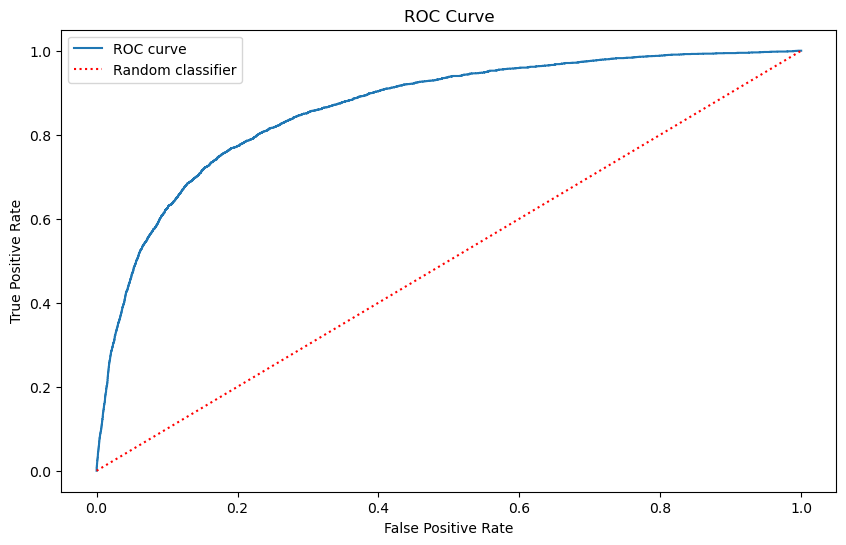

In [40]:
fpr, tpr, thresholds = roc_curve(y_val, lgb_pred)

plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'r:', label='Random classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Model Interpretation with `SHAP`

## Для интерпретации модели LightGBM используем `SHAP`, позволяющий оценить вклад каждого признака в предсказание как на уровне отдельных наблюдений, так и глобально по выборке.

In [70]:
preprocess = best_lgbm.named_steps["preprocess"]
model = best_lgbm.named_steps["model"]

In [72]:
X_train_proc = preprocess.transform(X_train_raw)
X_val_proc = preprocess.transform(X_val_raw)

In [76]:
feature_names = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents',
       'PastDueAggregated']

X_train_proc = pd.DataFrame(X_train_proc, columns=feature_names)
X_val_proc = pd.DataFrame(X_val_proc, columns=feature_names)

In [82]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_proc)

D:\Anaconda\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


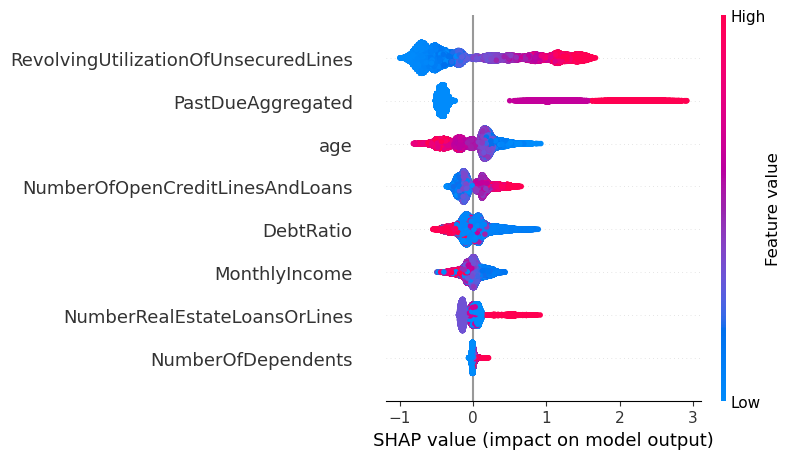

In [90]:
shap.summary_plot(shap_values, X_train_proc)

> Положительные значения SHAP двигают предсказание в сторону дефолта, отрицательные - в сторону благоприятного исхода. Причем величина значения показывает силу эффекта, а цвет и положение указывают значение и направление влияния

## Выводы из `summary_plot`:
### 1. Можно заметить разброс `SHAP` значений в большинстве признаков, что указывает на сложные зависимости. Если бы признак был линейным, без взаимодействий, то точки образовывали бы компактное облако
### 2. Высокое значение `RevolvingUtilizationOfUnsecuredLines`, отражающего общую сумму задолженности по кредитным картам и потребительским кредитным линиям, резко повышает риск дефолта. Соответственно, низкий показатель служит защитным фактором
### 3. Низкое значение просрочек по кредитам `PastDueAggregated` лишь слегка снижает риск дефолта, а вот высокие значения этого признака являются триггерным сигналом, существенно повышающим вероятность невыплаты кредита
### 4. С возрастом всё понятно: молодые заёмщики более рискованные, с ростом возраста падает риск дефолта.
### 5. Компактное облако наблюдается в `DebtRatio`, хотя высокие значения признака чаще снижает риск, что выглядит неожиданно. Может быть, `DebtRatio` важен в комбинации с доходом и просрочками, т.е. здесь зарыт interaction effect
### 6. В признаках `DebtRatio` и `MonthlyIncome` можно отметить легкую нестабильность эффекта (точки разных цветов смешаны, хоть и с преобладанием одного из цветов)
### 7. Наличие долгов по недвижимости `NumberRealEstateLoansOrLines` умеренно повышает риск

## Чтобы устранить сомнения насчет формы зависимостей, построим `dependence_plot`

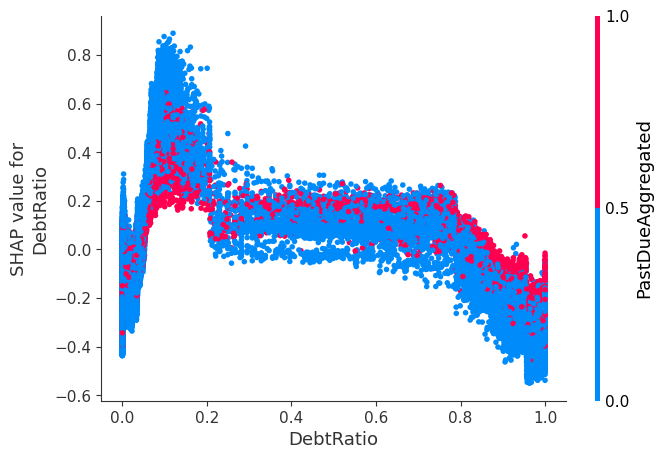

In [125]:
shap.dependence_plot(
    "DebtRatio",
    shap_values,
    X_train_proc,
    interaction_index="PastDueAggregated"
)

## Этот график показывает, как DebtRatio влияет на предсказание модели в зависимости от наличия просрочек

## Его можно разбить на 4 зоны:
### 1. В первой зоне низкие значения `DebtRatio` (≈ 0–0.05), где почти все значения `PastDueAggregated` низкие, так что `SHAP` значения отрицательны
### 2. Во второй зоне, где `DebtRatio` (≈ 0.05–0.2), наблюдается резкий скачок `SHAP` значений, т.е. эта зона воспринимается как зона максимального риска, что кажется странным на первый взгляд. Однако это объясняется тем, что просрочки уменьшают вклад `DebtRatio`. `SHAP` показывает, сколько конкретно этот признак "добавляет" к предсказанию модели. Когда есть просрочки, риск уже объяснён `PastDueAggregated`, и `DebtRatio` больше не добавляет столько же. В противном случае вклад `DebtRatio` в предсказание модели выше, поскольку риск не объясняется признаком `PastDueAggregated`.
### 3. Третья зона стабильна `DebtRatio` (≈ 0.2–0.8). `DebtRatio` здесь почти нейтрален, наличие просрочек по кредитам толкает предсказания в сторону дефолта
### 4. В четвертой зоне `DebtRatio` (≈ 0.8–1) видно, что рост значений `DebtRatio` приводит к снижению риска дефолта, что кажется парадоксальным. Здесь важно заметить, что относительно высокие значения `SHAP` в этой зоне обусловлены наличием просрочек. Для объектов с очень высоким `DebtRatio` и отсутствием просрочек вклад `DebtRatio` в предсказание модели минимален или отрицателен, поскольку основной риск уже объяснён другими признаками. При наличии просрочек вклад `DebtRatio` увеличивается, что подтверждает сильный эффект взаимодействия между признаками и перераспределение ответственности за предсказание в модели.

## Построим еще и `force_plot`:

In [165]:
shap.initjs()
explainer = shap.Explainer(model)
shap_values = explainer(X_val_proc)

i = 42
shap.force_plot(
    explainer.expected_value,
    shap_values[i].values,
    X_val_proc.iloc[i],
)

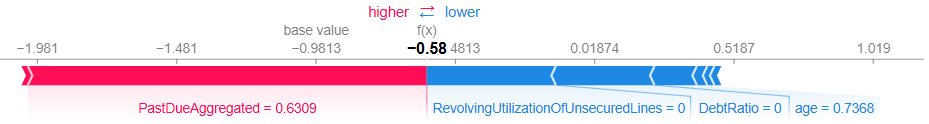

## SHAP force plot показывает, что основной вклад в риск дефолта для данного заемщика вносит наличие просрочек по кредитам, при этом возраст снижает риск дефолта. Низкие значения `DebtRatio` и `RevolvingUtilizationOfUnsecuredLines`, в свою очередь, частично компенсируют риск, в результате чего итоговое предсказание модели остаётся умеренным

--------

## Можно получить пару инсайтов:
* ### `DebtRatio` опасен только при определённых условиях
* ### Наличие/отсутствие просрочек сильно меняет интерпретацию долга

# В конечном итоге лучший результат показала модель LightGBM, сохраним её в качестве финальной модели

In [147]:
joblib.dump(best_lgbm, '../models/best_lgbm.joblib')

['../models/best_lgbm.joblib']